In [1]:
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import interpolate 
sys.path.append(r'C:\Chuji\Code_and_Data\MyCode')

import Circuit_Simulator 
import PulseGenerator as PG
from toolfunc import *
from toolfunc.adia_analysis import *
from toolfunc.pulse_filter import *
import scipy.optimize as sci_op
from toolfunc import DE

{'Q1_freq': '6000.0MHz', 'Q1_anhar': '-125.0MHz', 'Q2_freq': '1000.0MHz', 'Q2_anhar': '-50.0MHz', 'Q3_freq': '5800.0MHz', 'Q3_anhar': '-125.0MHz', 'g12': '97.9796MHz', 'g13': '-29.4958MHz', 'g23': '96.3328MHz'}


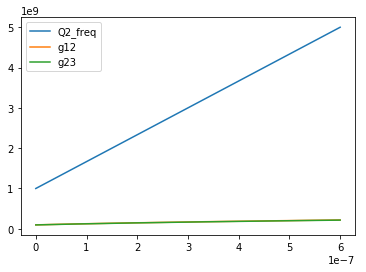

In [50]:
raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='ground',sampling_rate=1e9)
raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)

flux_pulse = np.linspace(1,0,601)
# flux_pulse = np.linspace(8/9,0/9,6000)
freq_arr =5e9 -flux_pulse * (5e9 - 1e9)

raw_config.setValue('Q1 f01_max',6.00e9)
raw_config.setValue('Q2 f01_max',5e9)
raw_config.setValue('Q3 f01_max',5.8e9)
raw_config.setValue('Q1 f01_min',1e9)
raw_config.setValue('Q2 f01_min',1e9)
raw_config.setValue('Q3 f01_min',1e9)
raw_config.setValue('Q1 Ec',0.25e9)
raw_config.setValue('Q2 Ec',0.1e9)
raw_config.setValue('Q3 Ec',0.25e9)

raw_config.setValue('r12',0.04)
raw_config.setValue('r23',0.04)
raw_config.setValue('r13',-0.005)

raw_config.setValue('Q2 Voltage period',-1)
raw_config.setValue('Q2 Voltage operating point',0)
raw_config.setValue('Q2 Flux',flux_pulse)

simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
Simulator = Circuit_Simulator.Simulator(simu_config)
Simulator.show_pulse()

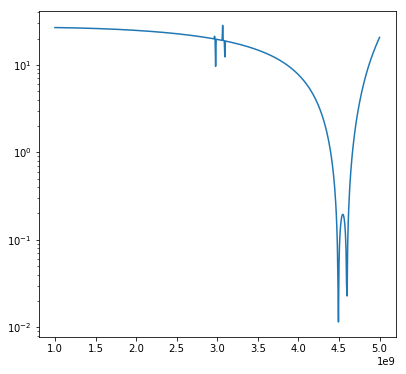

In [51]:
Simulator.performsimulation(solver_type=2,resample_factor=1,eigen_cloest_to_bare=False ,sort_by_maximum_overlap=True,gap=12e6)

fig = plt.figure(figsize=[6.4,6])
ax = fig.add_subplot(111)

eigen_trace = Simulator.EigenResult.get_Ener_gap_trace('101-100-001+000')
ax.plot(freq_arr,np.abs(eigen_trace)/1e6)

ax.set_yscale('log')

In [47]:
def cost_func(pulse_params,*args):
    gate_time,SRATE=args
    total_len = gate_time + 10e-9
    
    lamb1 = pulse_params

    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Adiabatic',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,min_C=1e9,down_tuning=True,F_Terms=1,Lcoeff=np.array(lamb1),Q1_freq=6.0e9,
                 CPLR_idle_freq=4.95e9,Q2_freq=5.8e9,constant_coupling=False,r1c=0.03,r2c=0.03,r12=-0.005,anhar_CPLR=-100e6,
                 anhar_Q1=-250e6,anhar_Q2=-250e6,negative_amplitude=False,dfdV=4.95e9-1e9,gap_threshold=8e6,freqpoints=301,pulsepoints=401)
    Seq.add_filter('Gauss Low Pass',300e6)
    flux_pulse=Seq.get_sequence()
    flux_pulse[flux_pulse>0.5]=0.5

    raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='-Z+Z+Z',sampling_rate=SRATE)
    raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
    raw_config.setValue('Q1 f01_max',6.00e9)
    raw_config.setValue('Q2 f01_max',4.95e9)
    raw_config.setValue('Q3 f01_max',5.8e9)
    raw_config.setValue('Q1 f01_min',1e9)
    raw_config.setValue('Q2 f01_min',1e9)
    raw_config.setValue('Q3 f01_min',1e9)
    raw_config.setValue('Q1 Ec',0.25e9)
    raw_config.setValue('Q2 Ec',0.1e9)
    raw_config.setValue('Q3 Ec',0.25e9)

    raw_config.setValue('r12',0.03)
    raw_config.setValue('r23',0.03)
    raw_config.setValue('r13',-0.005)
    raw_config.setValue('Q2 Voltage period',-1)
    raw_config.setValue('Q2 Voltage operating point',0)
    raw_config.setValue('Q2 Flux',flux_pulse)

    simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
    Simulator = Circuit_Simulator.Simulator(simu_config)

    Simulator.performsimulation(solver_type=1)
    Simulator.UnitaryResult.get_U(-1)
    Simulator.UnitaryResult.get_subspace_operator(['000','001','100','101'])
    Simulator.UnitaryResult.remove_single_qubit_gate()
    Simulator.UnitaryResult.set_Target_gate('CZ')
    Simulator.UnitaryResult.get_Gate_Fidelity()
    fidelity = Simulator.UnitaryResult.Gate_Fidelity

    print('lamb1:',lamb1)
    print('error:',1-fidelity)
    return 1 - fidelity

In [49]:
SRATE=10e9
gate_time_arr =[50e-9]
raw_initial_seeds=np.array([0.5])

for gate_time in gate_time_arr:
    time_start = time.time()
    DATA = sci_op.minimize(cost_func,raw_initial_seeds,args=(gate_time,SRATE), method='Nelder-Mead', options={'disp': True,'ftol':1e-5,'xtol':1e-5,'maxiter':30})



lamb1: [0.5]
error: 0.6537344211797373
lamb1: [0.525]
error: 0.6278158108890495
lamb1: [0.55]
error: 0.5954272859814704
lamb1: [0.575]
error: 0.5549433818252348
lamb1: [0.625]
error: 0.44141214944260065
lamb1: [0.675]
error: 0.2698225157396763
lamb1: [0.775]
error: 0.05005605814118208
lamb1: [0.875]
error: 0.0017016963330694912
lamb1: [1.075]
error: 0.07735656538054847
lamb1: [0.975]
error: 0.0206944135715722
lamb1: [0.775]
error: 0.05005605814118319
lamb1: [0.925]
error: 0.0043776364457720485
lamb1: [0.825]
error: 0.014287562367537365
lamb1: [0.9]
error: 0.0012137777247407389
lamb1: [0.925]
error: 0.0043776364457720485
lamb1: [0.8875]
error: 0.0009517352365724374
lamb1: [0.875]
error: 0.0017016963330797052
lamb1: [0.89375]
error: 0.0009762880355121961
lamb1: [0.88125]
error: 0.0011978799291536557
lamb1: [0.890625]
error: 0.0009662820603667521
lamb1: [0.884375]
error: 0.0010954439256587456
lamb1: [0.8890625]
error: 0.0007338438303572392
lamb1: [0.890625]
error: 0.0009662820603667521
la

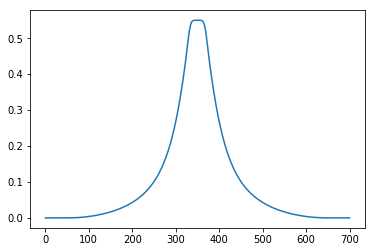

In [42]:
lamb1=0.58
gate_time=60e-9
total_len = gate_time + 10e-9
SRATE=10e9

Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
Seq.clear_pulse(tips_on=False)
Seq.add_pulse('Adiabatic',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=1,Lcoeff=np.array(lamb1),min_C=1e9,down_tuning=True,Q1_freq=6.0e9,
             CPLR_idle_freq=4.95e9,Q2_freq=5.8e9,constant_coupling=False,r1c=0.03,r2c=0.03,r12=-0.005,anhar_CPLR=-100e6,
             anhar_Q1=-250e6,anhar_Q2=-250e6,negative_amplitude=False,dfdV=4.95e9-1e9,gap_threshold=8e6,freqpoints=301,pulsepoints=401)
Seq.add_filter('Gauss Low Pass',300e6)
flux_pulse=Seq.get_sequence()
plt.plot(flux_pulse)

In [44]:
np.min(flux_pulse,0.5)

TypeError: 'float' object cannot be interpreted as an integer

In [45]:
flux_pulse[flux_pulse>0.5]=0.5

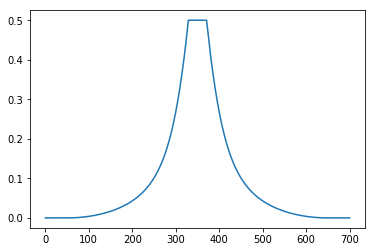

In [46]:
plt.plot(flux_pulse)